In [97]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries


using Pkg
Pkg.add("CairoMakie")
Pkg.add(name="CairoMakie", version="latest") 
Pkg.status("CairomMakie")

using CairoMakie

   Resolving package versions...
  No Changes to `C:\Users\Tom Cummings\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Tom Cummings\.julia\environments\v1.11\Manifest.toml`


LoadError: ArgumentError: invalid base 10 digit 'l' in "latest"

In [72]:
Lx = 100kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))

                       

48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── Bounded  x ∈ [-50000.0, 50000.0] regularly spaced with Δx=2083.33
├── Flat y                           
└── Bounded  z ∈ [-1000.0, 0.0]      regularly spaced with Δz=125.0

In [73]:
f = 1e-4
α = 0

u_background = XFaceField(grid)
u_background .= -α * xnodes(grid, Face(), Center(), Center())
background_flow = AdvectiveForcing(u = u_background)

AdvectiveForcing:
├── u: 49×1×8 Field{Face, Center, Center} on RectilinearGrid on CPU
├── v: ZeroField{Int64}
└── w: ZeroField{Int64}

In [74]:
model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = background_flow, v = background_flow, w = background_flow, b = background_flow))


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [75]:
# Initial condition setup (similar to your code but adjusted for frontogenesis)
N² = 1e-6  # [s⁻²] background stratification
M² = 1e-6  # [s⁻²] horizontal buoyancy gradient (front strength)

Δx = 10kilometers  # initial front width
Δb = Δx * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude

ramp(x, Δx) = min(max(0, x/Δx + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, Δx) + ϵb * randn()

set!(model, b=bᵢ, u=0, v=0, w=0)  # Start from rest


In [76]:
simulation = Simulation(model, Δt=20minutes, stop_time=30days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 30 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [77]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.1, max_Δt=20minutes)

In [78]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostic/Output

In [79]:
# Output setup
filename = "frontogenesis_2D"
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true 
) 

JLD2Writer scheduled on TimeInterval(12 hours):
├── filepath: frontogenesis_2D.jld2
├── 5 outputs: (b, ζ, u, v, w)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 41.4 KiB

In [80]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 10.949 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info:     ... simulation initialization complete (4.247 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (7.396 ms).


[01.87%] i: 100, t: 13.436 hours, wall time: 3.487 seconds, max(u): (1.332e+00, 1.559e+00, 5.380e-02) m/s, next Δt: 2.515 minutes
[02.54%] i: 200, t: 18.256 hours, wall time: 532.992 ms, max(u): (8.542e-01, 7.820e-01, 2.640e-02) m/s, next Δt: 3.584 minutes
[03.14%] i: 300, t: 22.636 hours, wall time: 529.977 ms, max(u): (1.323e+00, 1.981e+00, 4.627e-02) m/s, next Δt: 2.366 minutes
[03.77%] i: 400, t: 1.132 days, wall time: 570.481 ms, max(u): (4.860e-01, 2.347e+00, 3.011e-02) m/s, next Δt: 3.506 minutes
[04.53%] i: 500, t: 1.358 days, wall time: 451.247 ms, max(u): (1.040e+00, 1.066e+00, 3.535e-02) m/s, next Δt: 3.266 minutes
[05.34%] i: 600, t: 1.603 days, wall time: 509.857 ms, max(u): (1.274e+00, 1.413e+00, 2.563e-02) m/s, next Δt: 2.600 minutes
[05.96%] i: 700, t: 1.789 days, wall time: 424.095 ms, max(u): (8.364e-01, 2.163e+00, 2.498e-02) m/s, next Δt: 3.215 minutes
[06.78%] i: 800, t: 2.035 days, wall time: 496.944 ms, max(u): (1.035e+00, 1.433e+00, 1.809e-02) m/s, next Δt: 3.125

[ Info: Simulation is stopping after running for 39.183 seconds.
[ Info: Simulation time 30.000 days equals or exceeds stop time 30 days.
[ Info: Simulation completed in 39.247 seconds


In [81]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times

0.0:43200.00000000001:2.5920000000000005e6

In [82]:
# Coordinates
x = xnodes(grid, Center())# ./ 1e2  # km
z = znodes(grid, Center())# ./ 1e2  # km

8-element view(OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:11), 1:8) with eltype Float64:
 -937.5
 -812.5
 -687.5
 -562.5
 -437.5
 -312.5
 -187.5
  -62.5

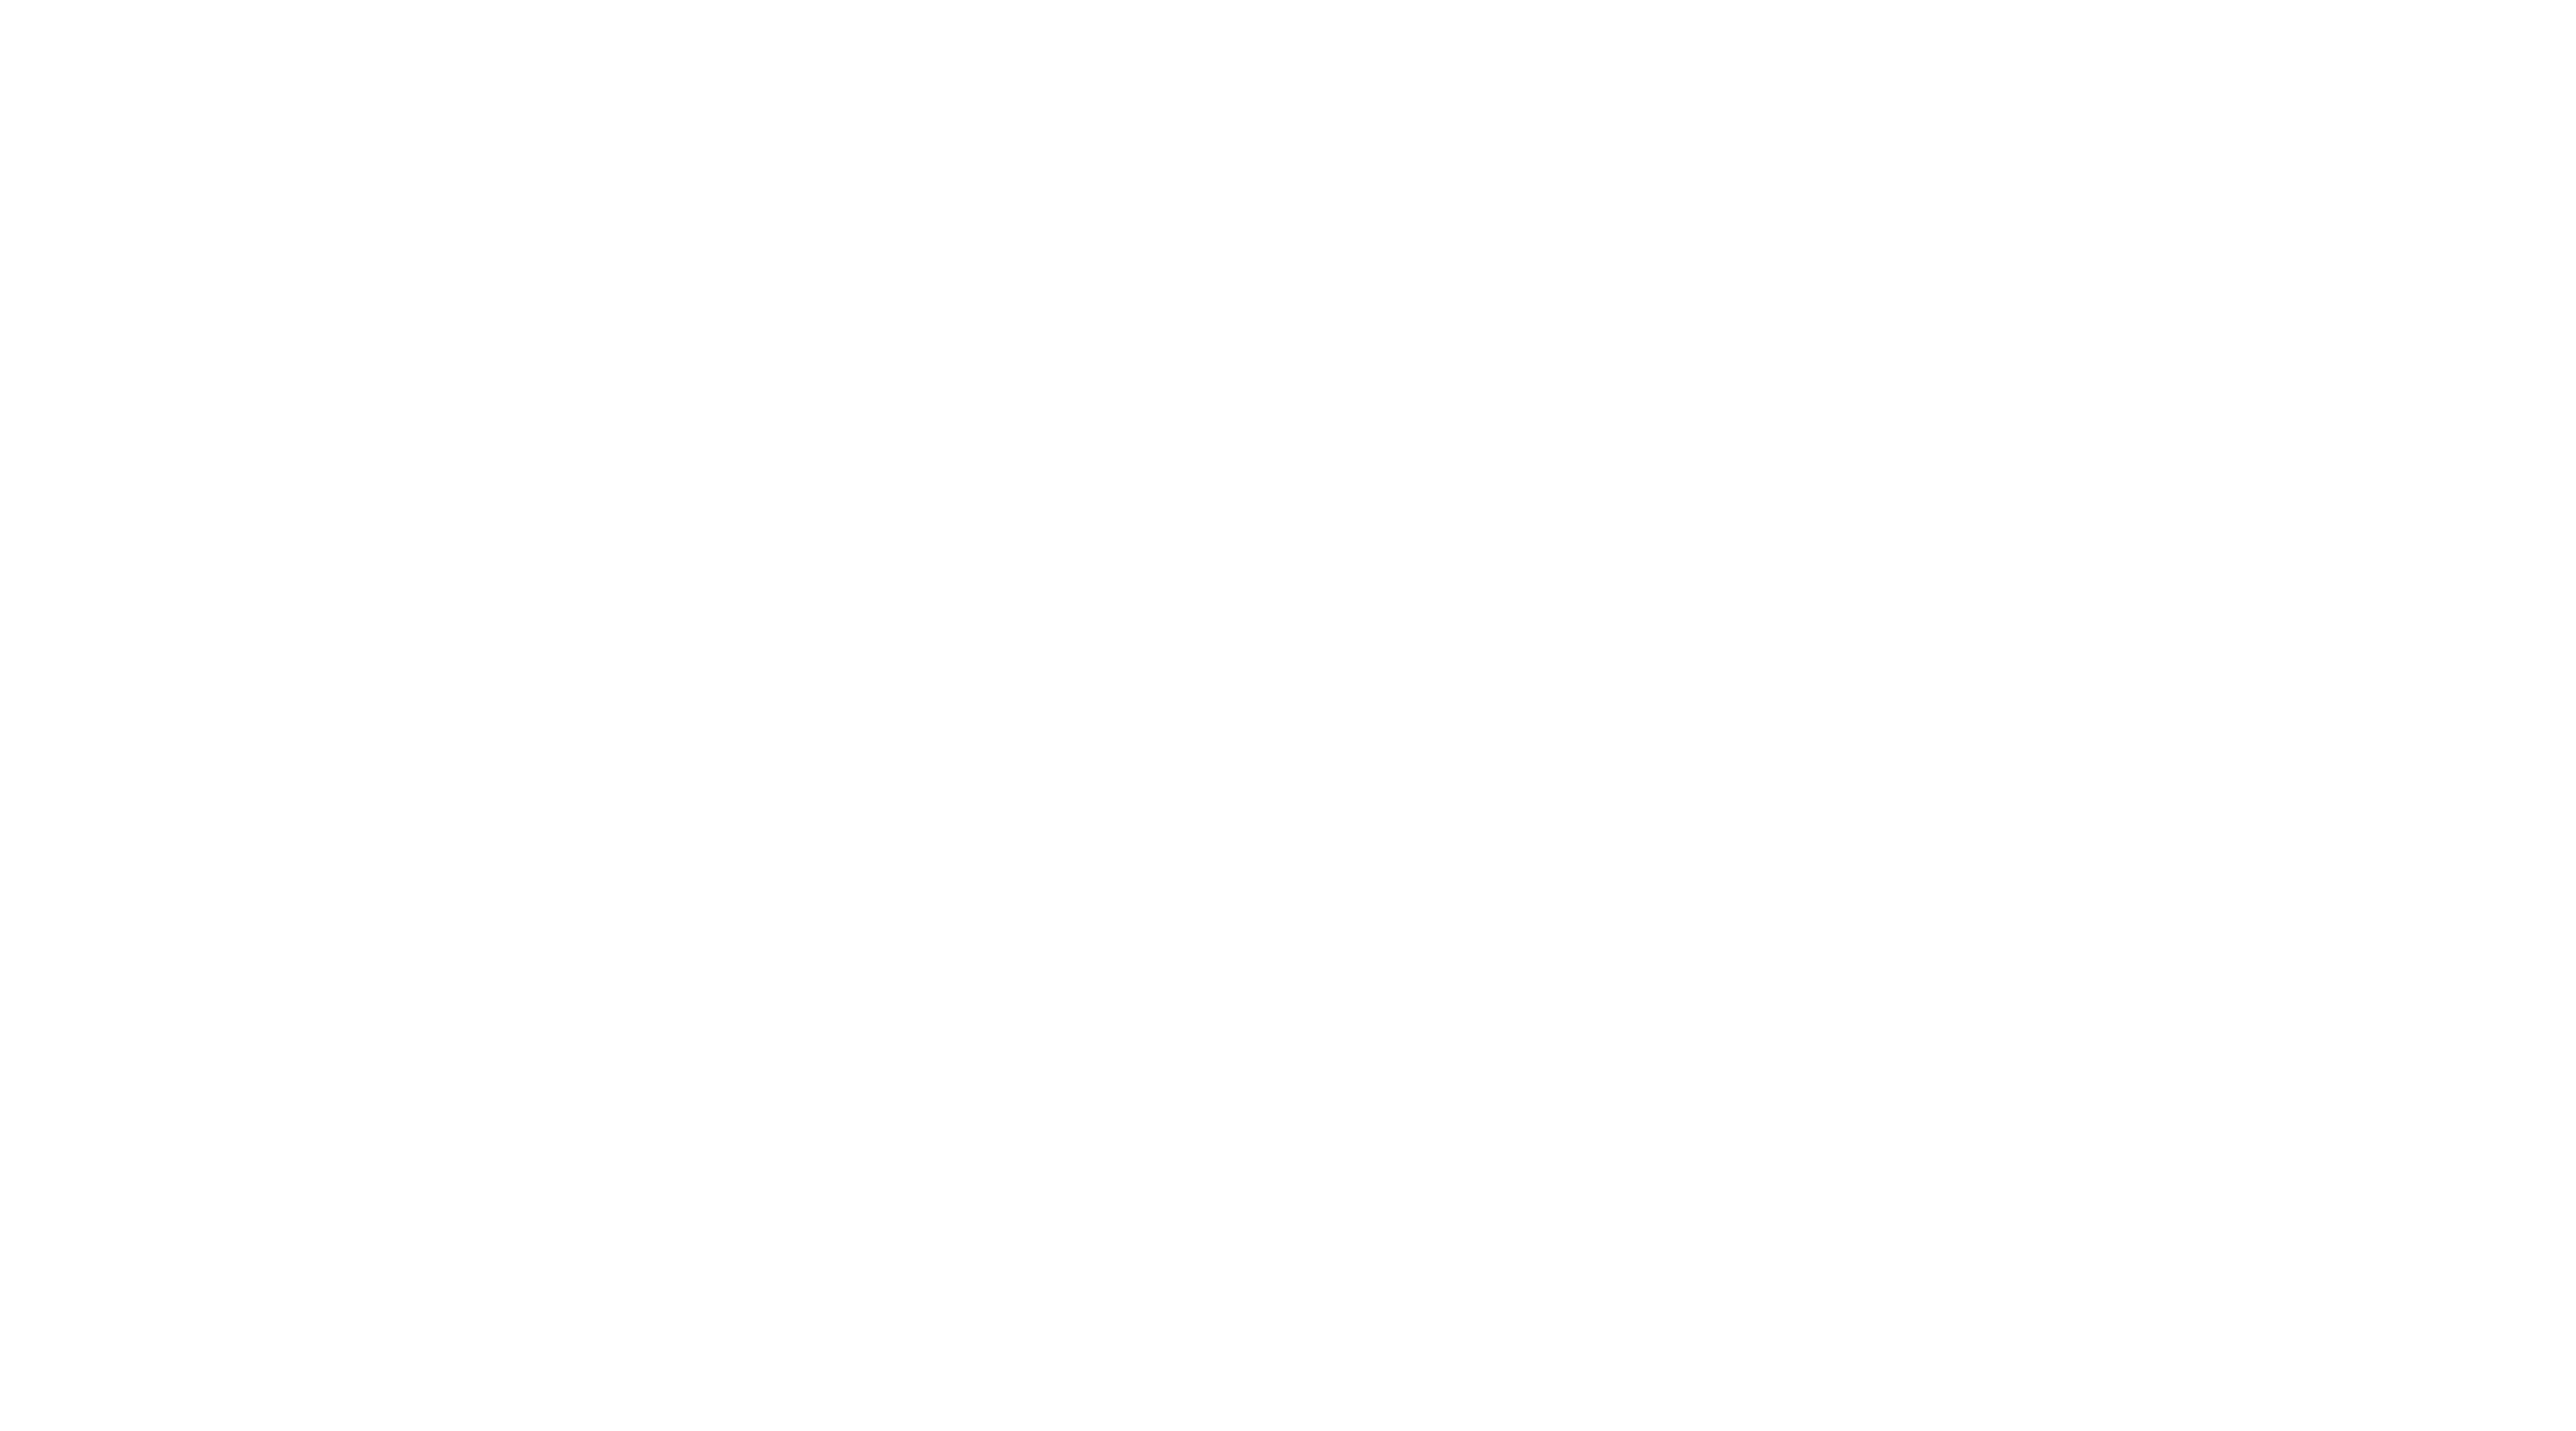

In [83]:
#using CairoMakie
fig = Figure(size=(1800, 1000))

In [84]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], 1, :, :)
ζ_slice = @lift interior(ζ_ts[$n], 1, :, :)

u_slice = @lift interior(u_ts[$n], 1, :, :)
v_slice = @lift interior(v_ts[$n], 1, :, :)
w_slice = @lift interior(w_ts[$n], 1, :, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


In [96]:
# Animations of Buoyancy and Vorticity



empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, x, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
contour!(ax_b, x, z, b_slice, levels=10, color=:black, linewidth=0.5)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")


# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, x, z, ζ_slice, colorrange=(-1e-1, 1e-1), colormap=:balance)
#contour!(ax_ζ, x, z, b_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 



LoadError: ArgumentError: Incompatible input axes in `Contour.contour`.

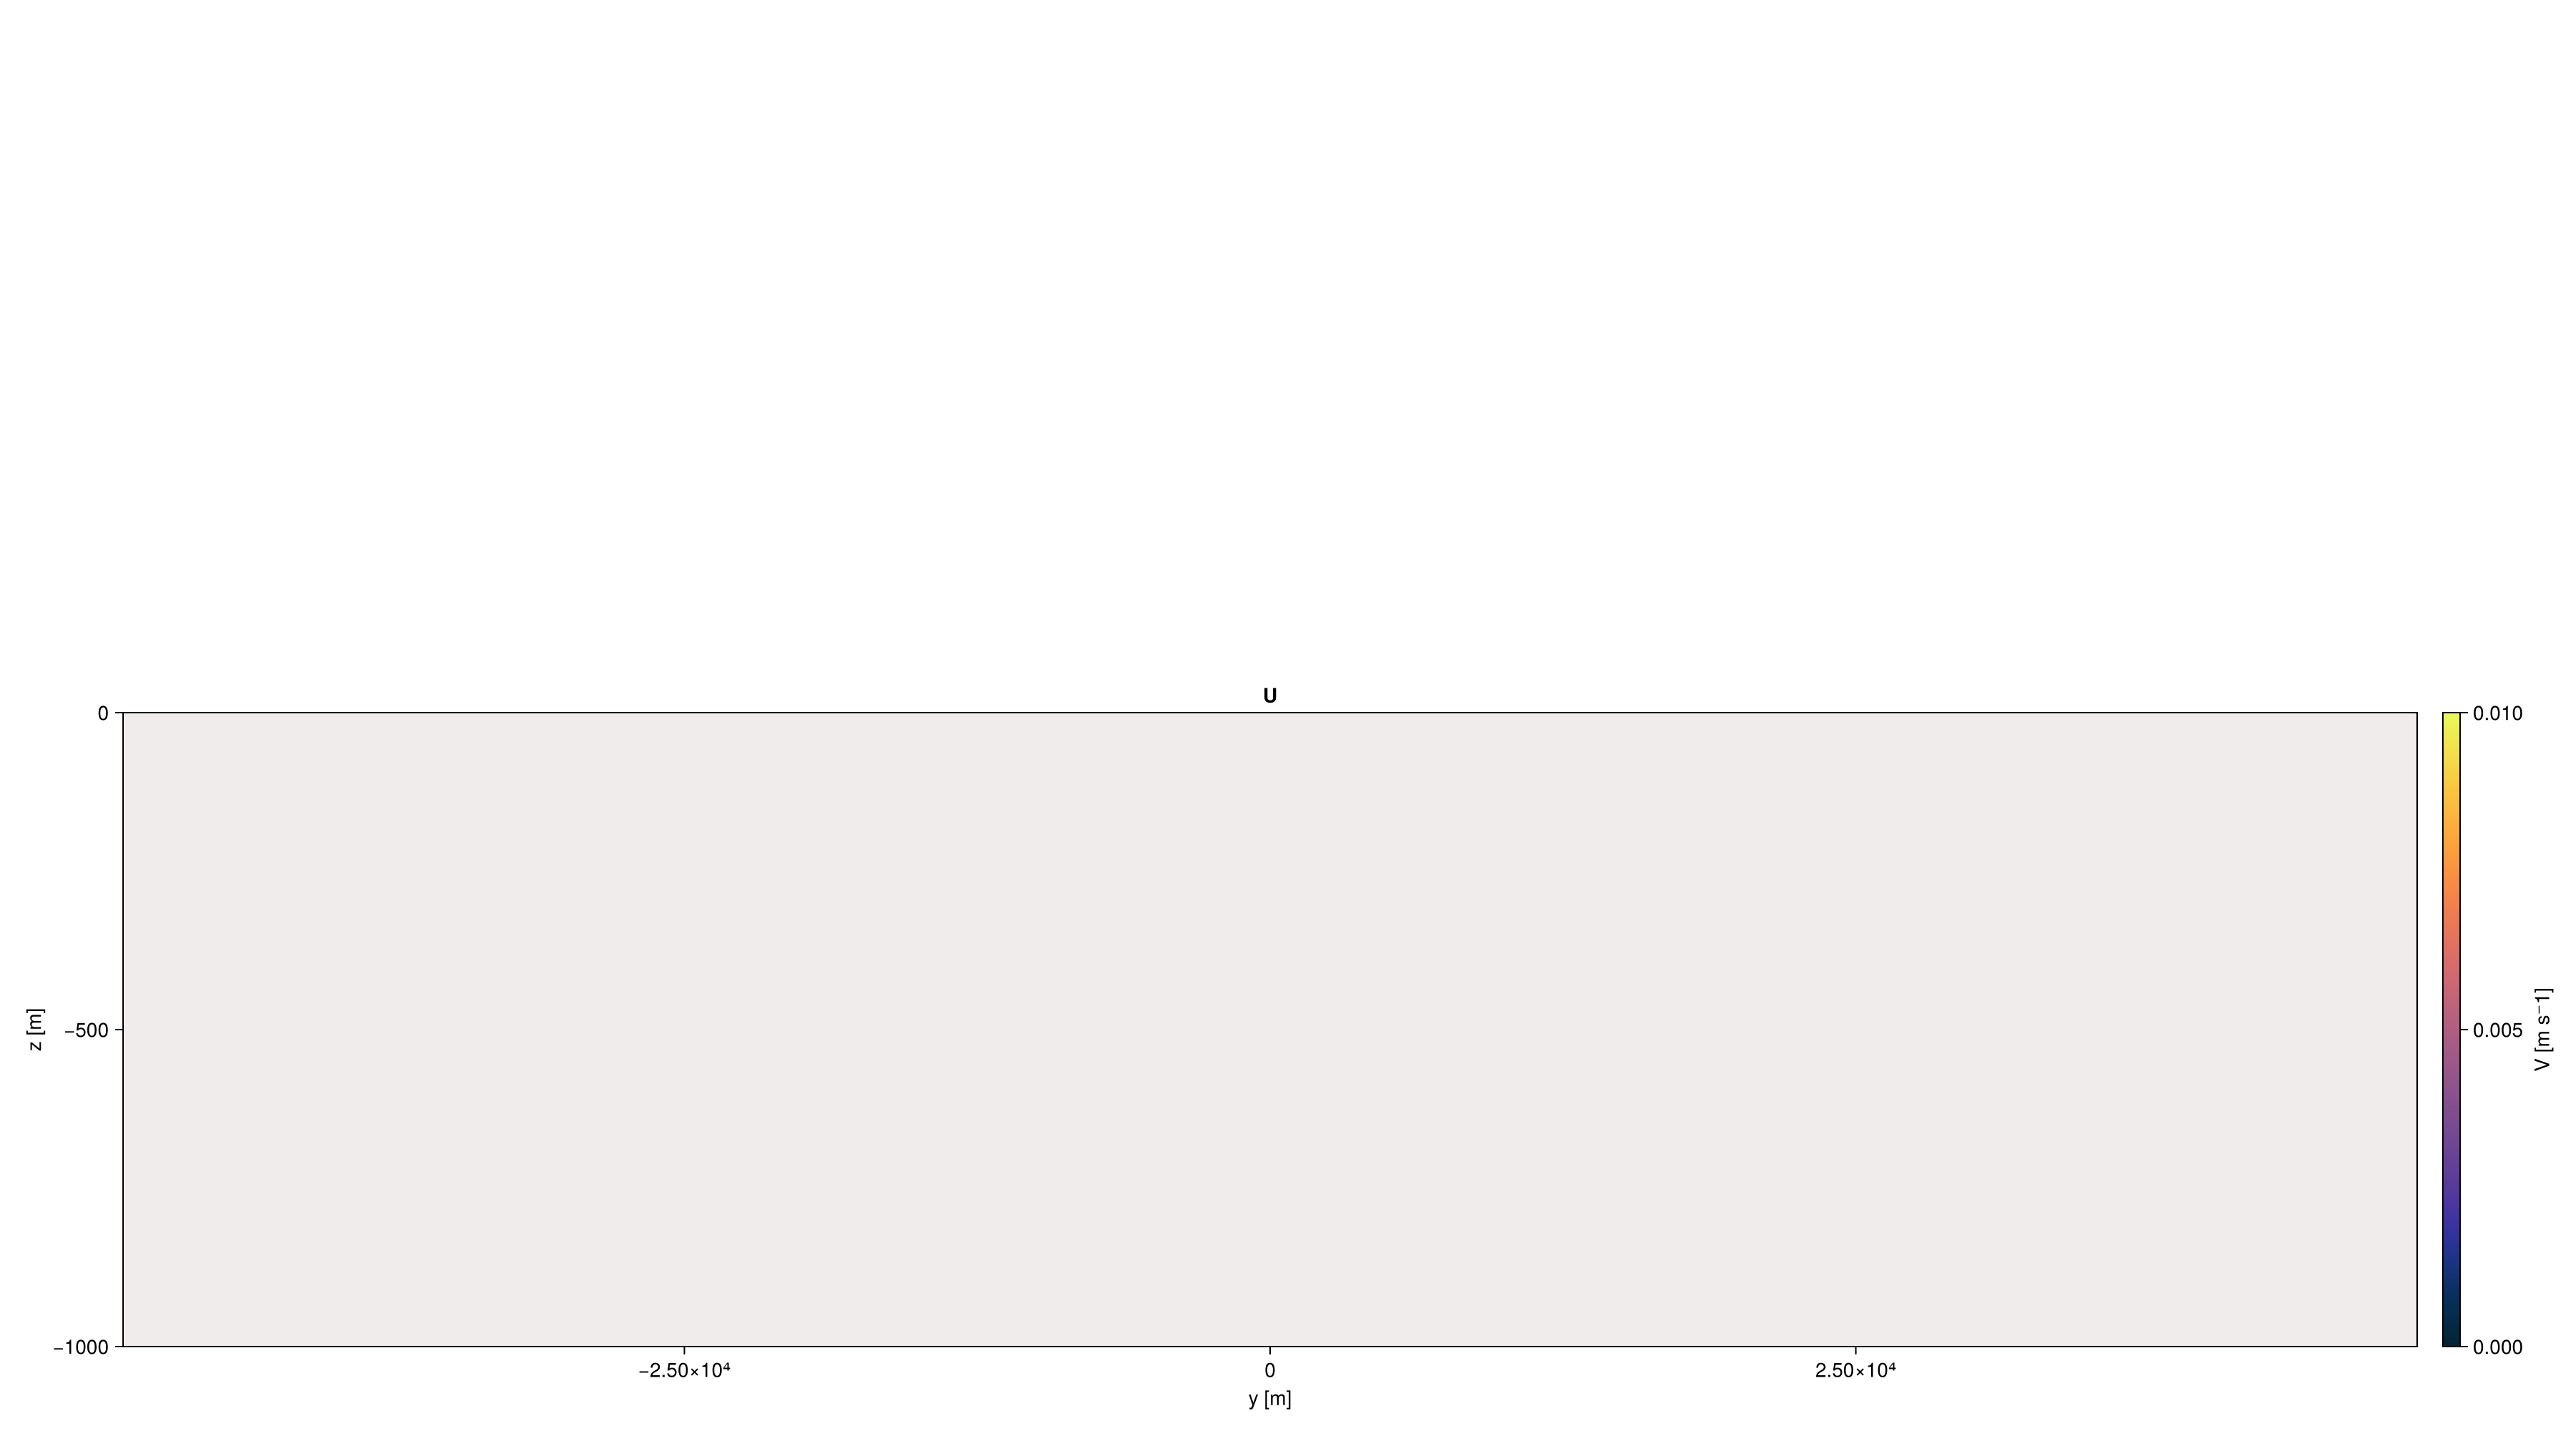

In [ ]:
#animation of U only

empty!(fig)

ax_u = Axis(fig[1, 1], title="U", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_u, x, z, u_slice; colorrange=(-1e-1, 1e-1), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
#contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame